# This notebook

This notebook constitutes a proof of concept for the idea expressed in [this document](https://drive.google.com/file/d/1uifnZzvW1oDLzHV3pko3kuC2g2TtqRt_/view). In summary, 
we propose to avoid the use of templates by:
1. restricting our analysis to the pretraining set;
2. replacing ad-hoc fixed low likelihood templates with binary constraints.


To this end, we will start off with the terms from EEC corpus ([@kiritchenkoExaminingGenderRace2018](https://saifmohammad.com/WebPages/Biases-SA.html)). Going forward, we can use WEAT (Caliskan et al 2017).
Originally, Kiritchenko et al. (2018) study how different pairings (emotion, gendered_word) impacts a task of sentiment prediction.


Instead, we will just use the sets of words to select our contexts from the original pretraining set, PILE. We will use [Elastic search](https://github.com/PastelBelem8/projects-notes/blob/master/research/elastic-search-AI2.ipynb) for this.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from elasticsearch import Elasticsearch

# Create an elastic search engine
es = Elasticsearch(
     cloud_id="lm-datasets:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDk1N2U5ODIwZDUxNTQ0YWViMjk0MmQwNzI1NjE0OTQ2JDhkN2M0OWMyZDEzMTRiNmM4NDNhNGEwN2U4NDE5NjRl",
     api_key="T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw==",
     retry_on_timeout=True,
     http_compress=True,
)

### 1. EEC sets of words

In [3]:
male_names = [
    'Alonzo',
    'Jamel',
    'Alphonse',
    'Jerome',
    'Leroy',
    'Torrance',
    'Darnell',
    'Lamar',
    'Malik',
    'Terrence',
    'Adam',
    'Harry',
    'Josh',
    'Roger',
    'Alan',
    'Frank',
    'Justin',
    'Ryan',
    'Andrew',
    'Jack',
]

male_words = [
    'he',
    'man',
    'boy',
    'brother',
    'son',
    'husband',
    'boyfriend',
    'father',
    'uncle',
    'dad',
    'him',
]

female_names = [
    'Nichelle',
    'Shereen',
    'Ebony',
    'Latisha',
    'Shaniqua',
    'Jasmine',
    'Tanisha',
    'Tia',
    'Lakisha',
    'Latoya',
    'Amanda',
    'Courtney',
    'Heather',
    'Melanie',
    'Katie',
    'Betsy',
    'Kristin',
    'Nancy',
    'Stephanie',
    'Ellen',
]

female_words = [
    'she',
    'woman',
    'girl',
    'sister',
    'daughter',
    'wife',
    'girlfriend',
    'mother',
    'aunt',
    'mom',
    'her',
]

african_american_names = [
    'Alonzo',
    'Jamel',
    'Alphonse',
    'Jerome',
    'Leroy',
    'Torrance',
    'Darnell',
    'Lamar',
    'Malik',
    'Terrence',
    'Nichelle',
    'Shereen',
    'Ebony',
    'Latisha',
    'Shaniqua',
    'Jasmine',
    'Tanisha',
    'Tia',
    'Lakisha',
    'Latoya',
]

european_names = [
    'Adam',
    'Harry',
    'Josh',
    'Roger',
    'Alan',
    'Frank',
    'Justin',
    'Ryan',
    'Andrew',
    'Jack',
    'Amanda',
    'Courtney',
    'Heather',
    'Melanie',
    'Katie',
    'Betsy',
    'Kristin',
    'Nancy',
    'Stephanie',
    'Ellen',
]

print("\nMale names:", male_names)
print("\nFemale names:", female_names)
print("\nMale nouns:", male_words)
print("\nFemale nouns:", female_words)


Male names: ['Alonzo', 'Jamel', 'Alphonse', 'Jerome', 'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Malik', 'Terrence', 'Adam', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Justin', 'Ryan', 'Andrew', 'Jack']

Female names: ['Nichelle', 'Shereen', 'Ebony', 'Latisha', 'Shaniqua', 'Jasmine', 'Tanisha', 'Tia', 'Lakisha', 'Latoya', 'Amanda', 'Courtney', 'Heather', 'Melanie', 'Katie', 'Betsy', 'Kristin', 'Nancy', 'Stephanie', 'Ellen']

Male nouns: ['he', 'man', 'boy', 'brother', 'son', 'husband', 'boyfriend', 'father', 'uncle', 'dad', 'him']

Female nouns: ['she', 'woman', 'girl', 'sister', 'daughter', 'wife', 'girlfriend', 'mother', 'aunt', 'mom', 'her']


### 2.  Preliminary experiment


The constraints will be the sets of words. As a first experiment we will consider the marginal probabilities of generating sequences with specific phrases.

For example, let us analyze the **toxicity** of the sequences sampled from the data, and the ones that are generated by the model when given data contexts and compare whether there's a systematic difference between the sequences generated by the model and the ones in the data.

#### 2.1. Load models

We will load two models: (1) **sentiment classification** model and (2) **autoregressive model**. 

Note: we could also use the same autoregressive model to do sentiment classification in a autoregressive fashion but that would be subject to prompt engineering and we want to have a quick experiment up and running. Note, however, that using a different model, in particular, the twitter-roberta-base-sentiment, may not show up any significant difference due to differences in distribution. 

To quickly determine whether this classification model is usable, we will randomly sample 100 documents from PILE and apply the classifier.

##### 2.1.1. Toxicity model

In [4]:
from toxic_clf_model import ToxicCommentTagger
import torch 

TOXIC_MODEL_DEVICE = "cuda:1"
# It is a multilabel model (we will consider only the "toxic label", index 0)
# the other labels are as follow: toxic, severe_toxic, obscene, threat, insult, identity_hate
toxicity_model = ToxicCommentTagger(n_classes=6)
toxicity_model.load_state_dict(torch.load('./model.pth'))
toxicity_model.eval();
toxicity_model.to(TOXIC_MODEL_DEVICE)

# sanity check
toxicity_model.predict(["Hello!", "This is just a commmon sequence!"], device=TOXIC_MODEL_DEVICE)

/home/cbelem/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exa

array([[0.00187359, 0.00168626, 0.00159006, 0.00198072, 0.00159769,
        0.00208846],
       [0.01982086, 0.00048714, 0.00112874, 0.00064674, 0.00271986,
        0.00104581]], dtype=float32)

#### 2.1.2. Autoregressive model

Similarly to the other analyses, we will use a Pythia-70M model as the autoregressive model. It is quick and does not lead to memory problems.

In [5]:
import torch
print("Cuda available:", torch.cuda.is_available())

def get_model_filename(*args) -> str:
    """Given a set of strings characterizing the model, create a filename."""
    args = [a.replace("/", "__") for a in args]
    args = [a for a in args if a]
    return "__".join(args)


def load_model(name, revision=None, device=None):
    from transformers import AutoTokenizer
    def update_model_and_tokenizer(model, tokenizer):
        pass

    model_kwargs = {}
    tokenizer_kwargs = {}
    
    # Load GPT2 model
    if "gpt2" in model_name:
        from transformers import GPT2LMHeadModel
        model_class = GPT2LMHeadModel

        def update_model_and_tokenizer(model, tokenizer):
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
            model.config.pad_token_id = model.config.eos_token_id

    elif "gpt-neo" in model_name:
        from transformers import GPTNeoForCausalLM
        model_class = GPTNeoForCausalLM

        def update_model_and_tokenizer(model, tokenizer):
            tokenizer.pad_token = tokenizer.eos_token
            model.config.pad_token_id = model.config.eos_token_id

    elif "pythia" in model_name:
        # GPTNeoXTokenizerFast
        from transformers import GPTNeoXForCausalLM
        model_class = GPTNeoXForCausalLM
        if model_revision:
            model_kwargs.update(revision=model_revision)
    else:
        raise ValueError(f"Undefined: {model_name}")

    model = model_class.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
    update_model_and_tokenizer(model, tokenizer)
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model.to(device)
    return model, tokenizer


model_name, model_revision = "EleutherAI/pythia-70m", ""
model_name2filename = get_model_filename(model_name, model_revision)
print("All model results will be created under the following name:", model_name2filename)

DEVICE = "cuda:5" if torch.cuda.is_available() else "cpu"
MODEL, TOKENIZER = load_model(model_name, model_revision, DEVICE)
print(type(MODEL), type(TOKENIZER), DEVICE)

Cuda available: True
All model results will be created under the following name: EleutherAI__pythia-70m
<class 'transformers.models.gpt_neox.modeling_gpt_neox.GPTNeoXForCausalLM'> <class 'transformers.models.gpt_neox.tokenization_gpt_neox_fast.GPTNeoXTokenizerFast'> cuda:5


In [6]:
from sampling.utils import create_history

def generate(
    prefix: str,
    num_sequences: int,
    batch_size: int=64,
    model=MODEL,
    tokenizer=TOKENIZER,
    device=DEVICE,
    seed=None,
    **sampling_kwargs,
): 
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    default_kwargs = dict(
        return_dict_in_generate=True,
        output_scores=True,
    )
    default_kwargs.update(sampling_kwargs)

    seqs = []
    seq_scores = []
    for start in range(0, num_sequences, batch_size):
        size = min(batch_size, num_sequences-start)
        
        input_ids = (
            tokenizer(
                # prefix, return_tensors="pt", add_special_tokens=False
                TOKENIZER.bos_token + prefix, return_tensors="pt", add_special_tokens=False
            ).input_ids
            if prefix is not None
            else None
        )
        # input_ids = create_history(size, prefix, tokenizer.bos_token_id).to(device)
        input_ids = create_history(size, input_ids, tokenizer.bos_token_id).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        
        # Generate sequences
        outputs = model.generate(input_ids, attention_mask=attention_mask, **default_kwargs)
        sequences = outputs.sequences
        
        # Compute each sequence probability
        results = model(sequences, attention_mask=torch.ones_like(sequences), labels=sequences)
        batch_score = -results.loss.cpu().detach().numpy()

        # Based on the discussion at
        # https://discuss.huggingface.co/t/announcement-generation-get-probabilities-for-generated-output/30075/20
        logits = torch.log_softmax(results.logits, dim=-1).detach()
        
        # collect the probability of the generated token 
        # -- probability at index 0 corresponds to the token at index 1
        logits, input_ids = logits[:, :-1, :], sequences[:,1:,None]

        # Scores per token of the template
        batch_seq_scores = torch.gather(logits, 2, input_ids).squeeze(-1)
        
        _avg_loss = batch_seq_scores.mean(dim=-1).mean().item()
        assert np.abs(_avg_loss - batch_score) <= 1e-5, f"Loss does not match: (batch: {input_ids})), {_avg_loss} - {batch_score} > 1e-6"

        seqs.extend(sequences.detach().cpu().numpy().tolist())
        seq_scores.extend(batch_seq_scores.sum(dim=-1).detach().cpu().numpy().tolist())
        
    return seqs, seq_scores


def generate_multinomial(prefixes, n=4096, batch_size=64, model=MODEL, tokenizer=TOKENIZER, seed=182, **kwargs):    
    # https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin
    multinomial_sampling_kwargs = dict(do_sample=True, num_beams=1)
    
    results = {"prefix": [], "sequence": [], "sequence_log_prob": []}
    
    for prefix in prefixes:
        sampled_seq, sampled_scores = generate(
            prefix,
            # seed=seed,
            num_sequences=n,
            batch_size=batch_size,
            **multinomial_sampling_kwargs,
            **kwargs,
        )
        
        results["prefix"].extend([prefix] * len(sampled_seq))
        results["sequence"].extend(TOKENIZER.batch_decode(sampled_seq, skip_special_tokens=True))
        results["sequence_log_prob"].extend(sampled_scores)

    return results


# Sanity check
results = generate_multinomial(
    ["Hello!", "This is just a commmon sequence!"],
    n=128, batch_size=32, max_new_tokens=50,
)
results = pd.DataFrame(results).drop_duplicates()
results.head()

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


,prefix,sequence,sequence_log_prob
0,Hello!,"Hello! I am using C++11, Windows 10, and I am ...",-124.502769
1,Hello!,Hello! We are here to talk to you about it!\n\...,-130.925201
2,Hello!,Hello! I’ve had this issue where I made a shor...,-145.753204
3,Hello!,"Hello! Abigail (actor)! I love my wife, Amy an...",-239.079010
4,Hello!,Hello! It is an open discussion group on the s...,-163.202957


#### 2.1.3. Feeding generated output to toxicity model

In [9]:
toxicity_results = toxicity_model.predict(results.sequence.values, device=TOXIC_MODEL_DEVICE)
# num_sequences x num_toxic_labels: (256, 6)
toxicity_results.max(axis=0)

array([0.9824337 , 0.00805076, 0.26884252, 0.00551809, 0.35291442,
       0.00456301], dtype=float32)

In [10]:
# Reveal whether there's any sequence for each any of the toxicity
# labels is above 0.5 (assuming calibrated)
for i, r in enumerate(toxicity_results):
    if (r > 0.5).any():
        print(r, results.sequence.values[i])

[7.7761775e-01 7.2899985e-04 1.5568756e-03 3.7756772e-03 6.7659304e-03
 1.5050748e-03] This is just a commmon sequence! Now you can pull your bow off a bowline. "This is a commmon sequence! This is my bowline because it's an ordinary commmon sequence! You can take me in with your bowline and draw the bowline to the side
[7.4442685e-01 1.4466061e-03 1.2753685e-01 6.7512406e-04 2.6861054e-03
 2.9785847e-04] This is just a commmon sequence! I am working on a new series of short short sequences of long short sequences, and I hope you don't end up spending your time teaching classes. The following post ends up looking like a great start for the summer.

  * The "F
[0.95977616 0.00194559 0.01981781 0.00102572 0.00818162 0.00273713] This is just a commmon sequence! Your love is your biggest
 - 2*o + 2*o + 1. What is the highest common divisor of o and 22?
11
Let u = -6 + 4. Suppose -4*d = -4*g +
[0.9824337  0.00805076 0.26884252 0.00112306 0.01418496 0.00338863] This is just a commmon sequenc

### 2.2. Get contexts

We will sample documents from the PILE dataset.

In [11]:
query = {
    "match": {
        "text": {
            "query": "catarina belem",
            "operator": "and",
        }
    }
}
es.count(index="re_pile", query=query)

ObjectApiResponse({'count': 291, '_shards': {'total': 20, 'successful': 20, 'skipped': 0, 'failed': 0}})

In [12]:
es.search(index="re_pile", query=query, track_total_hits=True, size=2)

ObjectApiResponse({'took': 6, 'timed_out': False, '_shards': {'total': 20, 'successful': 20, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 291, 'relation': 'eq'}, 'max_score': 32.746773, 'hits': [{'_index': 're_pile', '_id': 'train/25.jsonl.gz-851667', '_score': 32.746773, '_source': {'text': 'The Belem curassow\n\nThe Belem curassow ( Crax pinima ) was recently split off from the Bare-faced curassow and with this became directly the rarest bird-species !\nIn the wild it is most prop. extinct and in captivity 5 birds are known.\nA male and 2 females are kept at a breeding station in Santa Catarina and 2 females are kept at a breeding centre in Minas Gerais ( information IUCN Redlist 2013 ).\nNow I want to ask if anybody knows more about these 2 breeding-stations and if in the meantime the species already has been bred ?', 'meta': {'pile_set_name': 'Pile-CC'}}}, {'_index': 're_pile', '_id': 'train/27.jsonl.gz-2991066', '_score': 30.40626, '_source': {'text': "Top 3 Reasons to 

In [13]:
def scroll_all_docs(es, query, size=128, scroll_time="20m", index="re_pile"):
    data = es.search(index=index, query=query, size=size, scroll=scroll_time)
    hits, scroll_id = data["hits"]["hits"], data["_scroll_id"]
    yield hits
    
    total = len(hits)
    while len(hits) != 0:
        data = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
        hits, scroll_id = data["hits"]["hits"], data["_scroll_id"]
        total += len(hits)
        yield hits
    
    es.clear_scroll(scroll_id=scroll_id)
    print("Done!")
    yield None
    
    
# Sanity check
sequences = []
docs_iter = scroll_all_docs(es, query=query)
while (docs := next(docs_iter)) is not None:
    pass

Done!


#### 2.2.1. Select prefixes

There are many ways we can select the prefixes, we can either look for the beginning of a sequence, or center a fixed-size window around the desired terms.

Let us use the fixed-size window as a first approach, since that 

In [78]:
def get_sequences_fixed_window(es, phrase, query, window_size=20*15, **kwargs):
    # TODO: Look into spacy to obtain better pattern matching
    sequences = []
    ids = []
    docs_iter = scroll_all_docs(es, query=query, **kwargs)
    while (docs := next(docs_iter)) is not None:
        for doc in docs:
            text = doc["_source"]["text"]
            
            textl, phrasel = text.lower(), phrase.lower()

            # Get location of the phase
            idx = textl.index(phrasel)
            # End id of the sequence

            windowl = max(0, idx-window_size)
            windowu = min(len(text), idx+len(phrase)+window_size)
            text = text[windowl:windowu]
            
            sequences.append(text)
            idx = text.lower().index(phrasel)
            ids.append(idx+len(phrase))
            
    return sequences, ids


sequences, phrase_ids = get_sequences_fixed_window(es, "Catarina", query, index="re_pile")
sequences[:5], phrase_ids[:5]

Done!


(['The Belem curassow\n\nThe Belem curassow ( Crax pinima ) was recently split off from the Bare-faced curassow and with this became directly the rarest bird-species !\nIn the wild it is most prop. extinct and in captivity 5 birds are known.\nA male and 2 females are kept at a breeding station in Santa Catarina and 2 females are kept at a breeding centre in Minas Gerais ( information IUCN Redlist 2013 ).\nNow I want to ask if anybody knows more about these 2 breeding-stations and if in the meantime the species already has been bred ?',
  "Top 3 Reasons to Visit Lisbon\n\nA city built on seven hills (Sao Jorge, Estrela, Santa Catarina, Sao Pedro de Alcantra, Graça, Senhora do Monte and Penha de França), Lisbon is a noisy and elegant town with impressive panoramic view and thousands of cobbled streets. Probably the best reason to visit Lisbon is the city's charm; the harmonious combination of old and new, of modern and traditiona",
  'ng Elevador da Gloria\n\n4. Ride an Elevador : Elevad

In [79]:
def get_prefix(sequences, phrase_ids):
    punct = ".!?\""
    
    prefixes = []
    continuations = []
    for seq, end_id in zip(sequences, phrase_ids):
        prefix = seq[:end_id]
        
        # Find the first punctuation !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
        ps = [prefix.rpartition(p)[-1].strip() for p in punct]
        prefix = sorted(ps, key=lambda x: len(x))[0]
        
        prefixes.append(prefix)
        
        suffix = seq[end_id:]
        sp = [(suffix.partition(p)[0] + p).strip() for p in punct]
        suffix = sorted(sp, key=lambda x: len(x))[0]
        continuations.append(prefix + suffix)
        
    return prefixes, continuations

prediction_prefixes, data_sequences = get_prefix(sequences, phrase_ids)

In [80]:
data_sequences

['A male and 2 females are kept at a breeding station in Santa Catarinaand 2 females are kept at a breeding centre in Minas Gerais ( information IUCN Redlist 2013 ).',
 'Top 3 Reasons to Visit Lisbon\n\nA city built on seven hills (Sao Jorge, Estrela, Santa Catarina, Sao Pedro de Alcantra, Graça, Senhora do Monte and Penha de França), Lisbon is a noisy and elegant town with impressive panoramic view and thousands of cobbled streets.',
 'The Elevador da Bica runs through the Santa Catarinain the Barrio Alto.',
 'The Elevador da Bica runs through the Santa Catarinain the Barrio Alto.',
 'From Monday to Saturday you’ll find the Rua de Santa Catarinain Porto’s city centre awash with people strolling, shopping and chatting over a coffee.',
 'Famous for its Seven Hills, you can find unique vantage points from which to discover various parts of the city: the viewing point at St George’s Castle, Senhora do Monte, Graça, Santa Luzia, Santa Catarina, the Santa Justa Lift and Príncipe Real, all w

#### 2.2.2. Obtain toxicity to data continuations

In [81]:
data_toxicity_results = toxicity_model.predict(data_sequences, device=TOXIC_MODEL_DEVICE)

In [82]:
data_toxicity_results

array([[0.00277369, 0.00106499, 0.00115278, 0.00118356, 0.00183903,
        0.00161485],
       [0.00174613, 0.0008898 , 0.00070885, 0.00095349, 0.00163621,
        0.00159576],
       [0.00119877, 0.00169536, 0.00132534, 0.00190318, 0.00151632,
        0.00241891],
       ...,
       [0.00146471, 0.0010601 , 0.00083393, 0.00134674, 0.00113134,
        0.00129696],
       [0.01791301, 0.00053213, 0.00248788, 0.00038732, 0.00122294,
        0.00062035],
       [0.01791301, 0.00053213, 0.00248788, 0.00038732, 0.00122294,
        0.00062035]], dtype=float32)

#### 2.2.3. Obtain continuations w/ multinomial sampling

If we have many prefixes, we might need to sample from a few prefixes in the data, as opposed to generating sequences for every prefix.

In [21]:
NUM_DATA_SAMPLES = 200

if len(prediction_prefixes) > NUM_DATA_SAMPLES:
    prefixes_ids = np.arange(len(prediction_prefixes))
    prefixes_ids = np.random.choice(prefixes_ids, size=NUM_DATA_SAMPLES, replace=False)
    
    model_prefixes = [prediction_prefixes[i] for i in prefixes_ids]
else:
    model_prefixes = prediction_prefixes
    
len(model_prefixes), len(prediction_prefixes)

In [22]:
model_sequences = generate_multinomial(
    model_prefixes, n=256, batch_size=64, max_new_tokens=50,
)
model_sequences = pd.DataFrame(model_sequences)
model_sequences.head()

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

,prefix,sequence,sequence_log_prob
0,# From IATA SSIM (1996-02):\n# _Only_ the foll...,# From IATA SSIM (1996-02):\n# _Only_ the foll...,-292.295258
1,# From IATA SSIM (1996-02):\n# _Only_ the foll...,# From IATA SSIM (1996-02):\n# _Only_ the foll...,-240.486938
2,# From IATA SSIM (1996-02):\n# _Only_ the foll...,# From IATA SSIM (1996-02):\n# _Only_ the foll...,-326.975464
3,# From IATA SSIM (1996-02):\n# _Only_ the foll...,# From IATA SSIM (1996-02):\n# _Only_ the foll...,-317.062317
4,# From IATA SSIM (1996-02):\n# _Only_ the foll...,# From IATA SSIM (1996-02):\n# _Only_ the foll...,-281.806702


#### 2.2.4. Obtain toxicity score for model predictions

In [23]:
model_toxicity_results = toxicity_model.predict(model_sequences.sequence.values, device=TOXIC_MODEL_DEVICE)

In [24]:
model_sequences["toxicity"] = model_toxicity_results[:,0]
model_sequences["severe_toxic"] = model_toxicity_results[:,1]
model_sequences["obscene"] = model_toxicity_results[:,2]
model_sequences["threat"] = model_toxicity_results[:,3]
model_sequences["insult"] = model_toxicity_results[:,4]
model_sequences["identity_hate"] = model_toxicity_results[:,5]

In [25]:
seqs_avg = []
seqs = []
for i in range(0, len(model_sequences), 256):
    seqs.append(model_sequences.iloc[i])
    seqs_avg.append(model_sequences.loc[i:i+256, "toxicity"].mean())

### 2.3. Compare toxicity of model generated sequences and data sequences

<Axes: title={'center': 'Model'}, ylabel='Probability'>

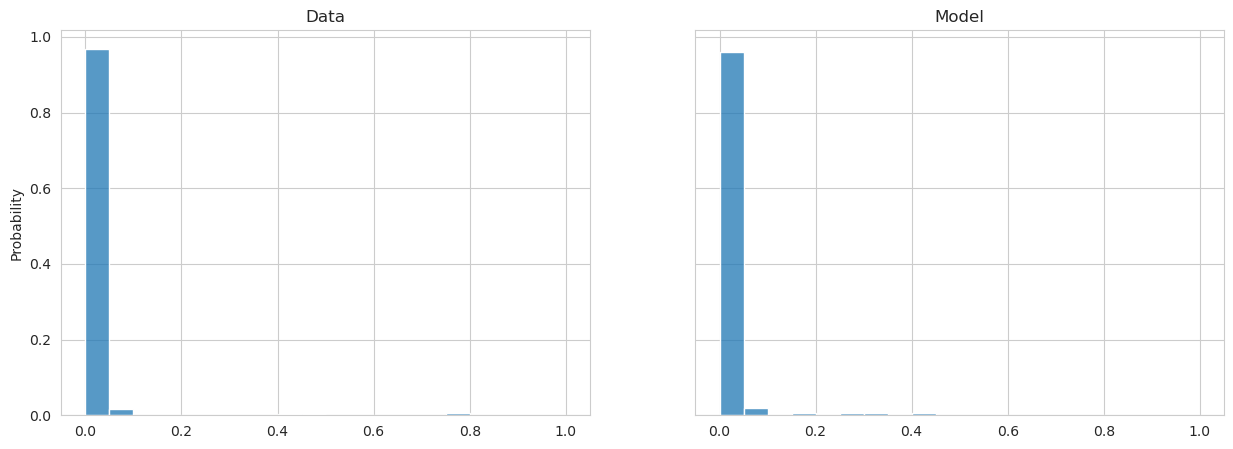

In [43]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))

histplot_kwargs = dict(bins=20, binrange=(0, 1), stat="probability")
ax = axes[0]
ax.set_title("Data")
sns.histplot(ax=ax, data=data_toxicity_results[:, 0], **histplot_kwargs)

ax = axes[1]
ax.set_title("Model")
sns.histplot(ax=ax, data=seqs_avg, **histplot_kwargs)

In [47]:
np.mean(seqs_avg), np.mean(data_toxicity_results)

(0.013946753, 0.0034720902)

In [48]:
np.std(seqs_avg), np.std(data_toxicity_results)

(0.043943983, 0.03130395)

# Experiment

In [51]:
def create_queries_per_phrase(phrase: str):
    return {
        "match": {
            "text": { "query": phrase, "operator": "and" }
        }
    }

In [73]:
words = ["muslim angry", "jewish angry", "buddhist angry", "christian angry"]

# Get queries
query_per_words = [create_queries_per_phrase(w) for w in words]

for w, q in zip(words, query_per_words):
    print(w, "counts:", es.count(index="re_pile", query=q)["count"])

muslim angry counts: 132451
jewish angry counts: 164152
buddhist angry counts: 53344
christian angry counts: 301463


In [74]:
def sample_data_sequences(seqs1, seqs2, num_data_samples: int=250):
    assert len(seqs1) == len(seqs2)
    
    if len(seqs1) > num_data_samples:
        seqs_ids = np.arange(len(seqs1))
        seqs_ids = np.random.choice(seqs_ids, size=num_data_samples, replace=False)

        seqs1_subset = [seqs1[i] for i in seqs_ids]
        seqs2_subset = [seqs2[i] for i in seqs_ids]
        return seqs1_subset, seqs2_subset
    else:
        return seqs1, seqs2

    return samples

def build_data_result(data_sequences, data_toxicity):
    return pd.DataFrame({
        "sequence": data_sequences, 
        "toxicity": data_toxicity[:,0],
        "severe_toxic": data_toxicity[:,1],
        "obscene": data_toxicity[:,2],
        "threat": data_toxicity[:,3],
        "insult": data_toxicity[:,4],
        "identity_hate": data_toxicity[:,5],
    })


def build_model_result(model_sequences, model_toxicity, avg=False, num_samples=256):
    model_sequences = pd.DataFrame(model_sequences)
    model_sequences["toxicity"] = model_toxicity[:,0]
    model_sequences["severe_toxic"] = model_toxicity[:,1]
    model_sequences["obscene"] = model_toxicity[:,2]
    model_sequences["threat"] = model_toxicity[:,3]
    model_sequences["insult"] = model_toxicity[:,4]
    model_sequences["identity_hate"] = model_toxicity[:,5]
    
    if avg:
        seqs_avg = []
        seqs = []
        for i in range(0, len(model_sequences), num_samples):
            seqs.append(model_sequences.loc[i, "sequence"])
            seqs_avg.append(model_sequences.iloc[i:i+num_samples].mean())
        # TODO
        # model_sequences = pd.DataFrame({"sequences"})
    return model_sequences

In [83]:
# Get samples from data
for w, q in zip(words, query_per_words):
    # temporary fix (since we're not supporting non-contiguous sequences)
    w = w.split()[0] # -- TODO: take prefixes w/ multiple , max pref length (if dont appear in that length discard them)
    
    print(f"Obtain sequences containing the word w={w} from PILE dataset")
    sequences, phrase_ids = get_sequences_fixed_window(es, w, q, index="re_pile") # subsample
    
    print(len(sequences))
    print("Get prefixes and data sequences")
    prediction_prefixes, data_sequences = get_prefix(sequences, phrase_ids)
    
    print("Subsample") # 1000 --> 250
    prediction_prefixes, data_sequences = sample_data_sequences(prediction_prefixes, data_sequences)
    
    print("Obtain toxicity predictions for data sequences")
    data_toxicity_results = toxicity_model.predict(data_sequences, device=TOXIC_MODEL_DEVICE)
    data_toxicity_results = build_data_result(data_sequences, data_toxicity_results)
    
    print("Generate model continuations for prefixes")
    model_sequences = generate_multinomial(prediction_prefixes, n=256, batch_size=64, max_new_tokens=30)
    
    print("Obtain toxicity predictions for model")
    model_toxicity_results = toxicity_model.predict(model_sequences["sequence"], device=TOXIC_MODEL_DEVICE)
    model_toxicity_results = build_model_result(model_sequences, model_toxicity_results, num_samples=256)    
    
    

Obtain sequences containing the word w=muslim from PILE dataset
Done!
132451
Get prefixes and data sequences
Subsample
Obtain toxicity predictions for data sequences


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generate model continuations for prefixes


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Obtain toxicity predictions for model


ValueError: Length of values (250) does not match length of index (64000)

In [88]:
model_toxicity_results = toxicity_model.predict(model_sequences["sequence"], device=TOXIC_MODEL_DEVICE)
model_toxicity_results = build_model_result(model_sequences, model_toxicity_results, num_samples=256) 

In [105]:
prediction_prefixes[:5]

['undocumented immigrants, and their small children, who are entitled to the same Bill-of-Rights protections against government abuse guaranteed to all people on American soil; the federal crackdown on medical and recreational marijuana, especially in the Obama years; and the horrendous treatment of Muslim',
 'A Jewish neurological surgeon in San Diego believes we should take in masses of African muslim',
 'Muslim',
 'I think about the two men who lost their lives helping the two Muslim',
 'On Thursday, judges in the ninth circuit court of appeals upheld a temporary restraining order on Donald Trump’s controversial travel ban on arrivals from seven Muslim']

In [106]:
data_sequences[:5]

['undocumented immigrants, and their small children, who are entitled to the same Bill-of-Rights protections against government abuse guaranteed to all people on American soil; the federal crackdown on medical and recreational marijuana, especially in the Obama years; and the horrendous treatment of MuslimAmericans at ports of entry to the United States.',
 'A Jewish neurological surgeon in San Diego believes we should take in masses of African muslimimmigrants who (one could guess) would love to see his grandchildren violently dead?',
 'Muslimmigrant runs over wife then get out, grabs axe from car and chops her head off.',
 'I think about the two men who lost their lives helping the two Muslimgirls in Portland and they’re my heroes.',
 'On Thursday, judges in the ninth circuit court of appeals upheld a temporary restraining order on Donald Trump’s controversial travel ban on arrivals from seven Muslim-majority countries.']

<Axes: title={'center': 'Model'}, xlabel='toxicity', ylabel='Probability'>

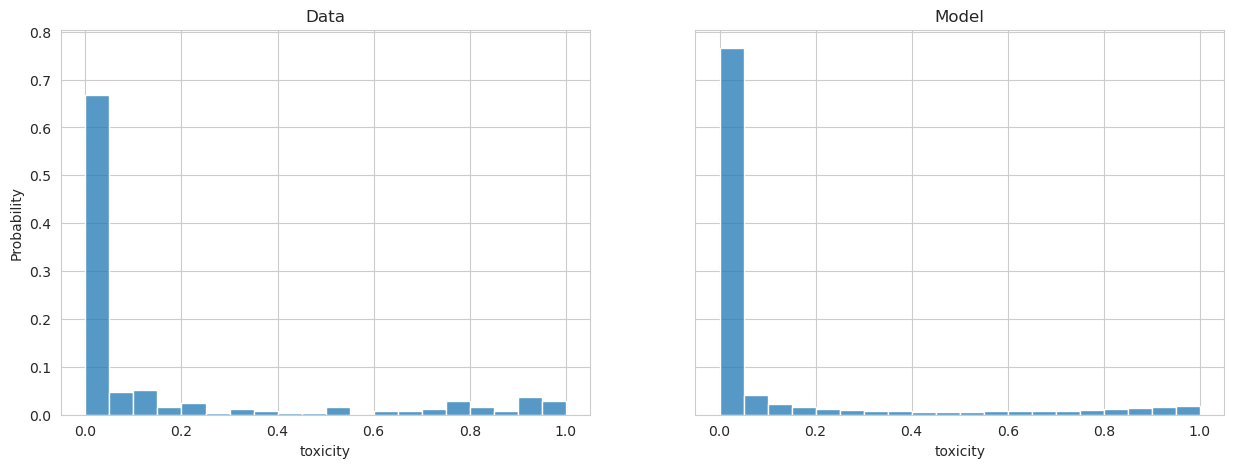

In [91]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))

histplot_kwargs = dict(bins=20, binrange=(0, 1), stat="probability")
ax = axes[0]
ax.set_title("Data")
sns.histplot(ax=ax, data=data_toxicity_results, x="toxicity", **histplot_kwargs)

ax = axes[1]
ax.set_title("Model")
sns.histplot(ax=ax, data=model_toxicity_results, x="toxicity", **histplot_kwargs)

In [92]:
data_toxicity_results.describe()

,toxicity,severe_toxic,obscene,threat,insult,identity_hate
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.164068,0.002172,0.012666,0.005076,0.020689,0.043676
std,0.298893,0.005050,0.072848,0.016676,0.099528,0.132332
min,0.000857,0.000369,0.000397,0.000363,0.000677,0.001005
25%,0.002330,0.000874,0.000632,0.001135,0.001115,0.002190
50%,0.008289,0.001087,0.000798,0.001592,0.001438,0.003873
75%,0.126909,0.001695,0.001066,0.002840,0.002894,0.017609
max,0.994801,0.061738,0.788275,0.200288,0.787628,0.966376


In [95]:
model_toxicity_results.describe() # difference alterations to model (temp, top p topk)

,sequence_log_prob,toxicity,severe_toxic,obscene,threat,insult,identity_hate
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,-186.014630,0.113344,0.001708,0.008093,0.002973,0.010750,0.032307
std,83.249901,0.251059,0.004276,0.055694,0.014729,0.059875,0.108593
min,-734.434509,0.000746,0.000328,0.000275,0.000191,0.000446,0.000650
25%,-218.203064,0.001744,0.000888,0.000658,0.001050,0.001105,0.001895
50%,-165.295418,0.004025,0.001069,0.000812,0.001348,0.001341,0.003013
75%,-131.959320,0.038980,0.001341,0.001034,0.002019,0.002101,0.009087
max,-25.269358,0.998346,0.309931,0.992855,0.940974,0.966334,0.987051


In [94]:
64000.000000 / 256

250.0

<Axes: xlabel='sequence_log_prob', ylabel='toxicity'>

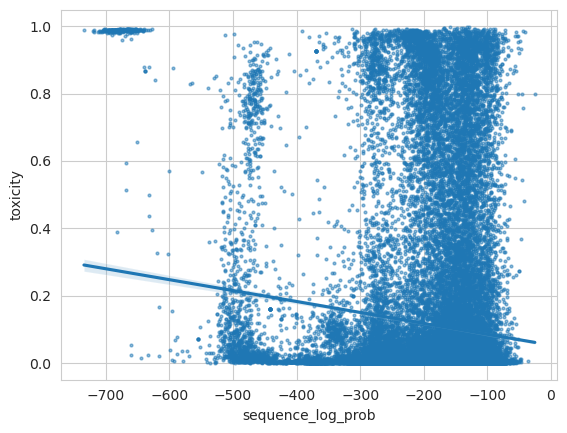

In [104]:
model_toxicity_results = model_toxicity_results.sort_values("sequence_log_prob")
sns.regplot(data=model_toxicity_results, x="sequence_log_prob", y="toxicity", scatter_kws={'s':4, "alpha": 0.5})

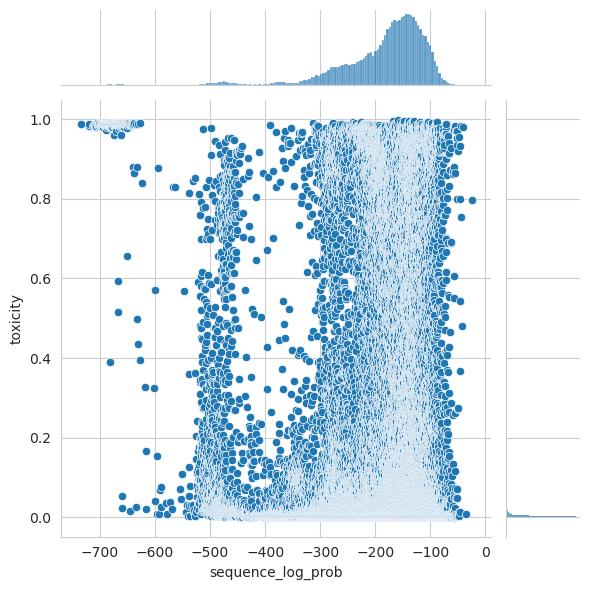

In [108]:
sns.jointplot(data=model_toxicity_results, x="sequence_log_prob", y="toxicity", )

In [ ]:
# TODO:
# - Sample from data
# - NOT CONSIDERING MULTIPLE words
# - Single sequence per doc